# <center>**Modélisation statistique avancée - Contrôle**</center>
### <center>20 Janvier 2025</center>

<center><a href="mailto:irene.balelli@inria.fr">irene.balelli@inria.fr</a></center>

## **Partie I. Questions de cours** 

**1.** Expliquez l'idée de l'estimation de la densité avec les $k$-plus-proches voisins.  Comment le choix de $k$ influence-t-elle l'estimation de la densité ?

**2.** Qu'est-ce qu'un régressogramme et comment est-il utilisé pour estimer une fonction de régression non paramétrique ?

**3.** Quels sont les avantages de la régression non paramétrique par rapport à la régression linéaire ?

Soit $K(x):=\frac{\pi}{4}\cos{\left(\frac{\pi}{2}x\right)}\mathbb{I}_{[-1,1]}(x)$, où $\mathbb{I}_{[-1,1]}(x)$ denote la fonction indicatrice, *i.e.* $\mathbb{I}_{[-1,1]}(x)=1$ si $x\in[-1,1]$, 0 sinon. 

**4.** $K$ est-elle bien une fonction de densité ? Démontrer.

*Rappel.* $\frac{d\sin(x)}{dx}=\cos(x)$; $\frac{d\cos(x)}{dx}=-\sin(x)$

* On observe tout d'abord que $K(x)\geq0$ pour tout $x\in\mathbb R$. En effet:
    * $K(x)=0$ si $x\leq-1$ ou $x\geq1$
    * $K(x)>0$ si $-1<x<1$ car la fonction $\cos$ est positive dans l'itervalle $\left]\frac{-\pi}{2},\frac{\pi}{2}\right[$
* $K(x)$ est intégrable
* Nous vérifions enfin que $\int_{\mathbb R}K(x)dx=1$ :

\begin{eqnarray}
\int_{\mathbb R}K(x)dx &=& \int_{\mathbb R}\frac{\pi}{4}\cos{\left(\frac{\pi}{2}x\right)}\mathbb{I}_{[-1,1]}(x)dx \\
&=& \int_{-1}^1\frac{\pi}{4}\cos{\left(\frac{\pi}{2}x\right)}dx \\
&=& \frac{\pi}{4}\left[\frac{2}{\pi}\sin{\left(\frac{\pi}{2}x\right)}\right]_{-1}^1 \\
&=& \frac{\pi}{4}\left(\frac{2}{\pi}\sin{\left(\frac{\pi}{2}\right)}-\frac{2}{\pi}\sin{\left(-\frac{\pi}{2}\right)}\right) \\
&=& \frac{\pi}{4}\left(\frac{2}{\pi}+\frac{2}{\pi}\right)=\frac{\pi}{4}\frac{4}{\pi}=1
\end{eqnarray}

**Bonus.** Représenter $K(x)$ dans un intervalle symétrique per rapport à l'origine.

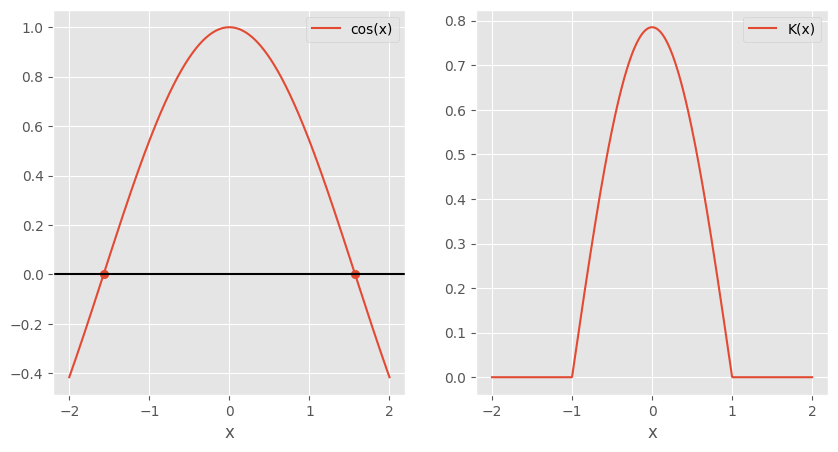

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def K(x):
    ind = 1 if ((x>=-1) and (x<=1)) else 0
    cos = np.cos(np.pi*x/2)
    return np.pi*cos*ind/4

x_lin = np.linspace(-2, 2, 1000)

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
K_x = np.cos(x_lin)
ax.plot(x_lin,K_x, label='cos(x)')
ax.scatter([-np.pi/2,np.pi/2],[0,0])
ax.axhline(color='k')
ax.set(xlabel='x')
plt.legend()

ax = fig.add_subplot(122)
K_x = np.array([K(x) for x in x_lin])
ax.plot(x_lin,K_x, label='K(x)')
ax.set(xlabel='x')
plt.legend()

## **Partie II. Application** 

Soit $Y$ une variable aléatoire dépendante de la variable aléatoire $X$ de la façon suivante :

$$g(x):=\mathbb E[Y|X=x]=10^{-4}(x+40)^3\exp{\left(\frac{-x+40}{20}\right)}$$

**1.** A l'aide de cette fonction moyenne, générer un dataset $\mathcal D_{N}$ contenant $N=200$ observations $(x_i,y_i)$ pour $x_1,\dots,x_N\in[0,100]$ et en supposant pour chaque $y_i$ un bruit gaussien centré de variance $\sigma^2=20$. Dans une même figure représentez la vrai fonction moyenne et les données.

In [2]:
def g(x):
    return 10**(-4)*(x+40)**3*np.exp((-x+40)/20)

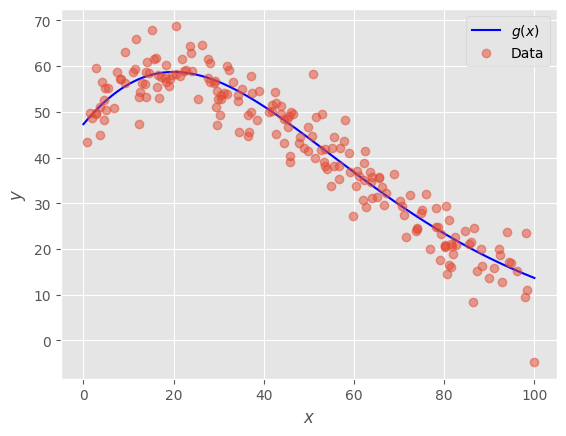

In [3]:
N = 200
X = np.random.uniform(0,100,N)
Y = g(X) + np.random.normal(scale=np.sqrt(20),size=[N])

fig, ax = plt.subplots(1, 1)

x_lin = np.linspace(0,100,1000)
ax.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
ax.plot(X, Y, 'o', alpha=0.5, label='Data')
ax.set(xlabel='$x$', ylabel='$y$')
ax.legend(loc='best')

**2.** Soit $K(x):=\frac{\pi}{4}\cos{\left(\frac{\pi}{2}x\right)}\mathbb{I}_{[-1,1]}(x)$. Écrire explicitement la formule qui donne la régression par noyau $K$, puis l'implémenter. Vous pouvez définir une `classe` ou utiliser des fonctions.

Soit $x\in\mathbb R$. L'estimation de sa valeur $y$ correspondante $\hat g_{\nu}^K(x)$ avec le noyau $K$ est obtenue de la manière suivante :
$$\hat g_{\nu}^K(x)=\frac{\sum_{i=1}^N\cos{\left(\frac{\pi(x-x_i)}{2\nu}\right)}\mathbb{I}_{[-1,1]}\left(\frac{x-x_i}{\nu}\right)y_i}{\sum_{i=1}^N\cos{\left(\frac{\pi(x-x_i)}{2\nu}\right)}\mathbb{I}_{[-1,1]}\left(\frac{x-x_i}{\nu}\right)}$$

In [4]:
class KRegression:

    def __init__(self,X,Y,bw=1):
        # X: independent variable (np.array)
        # Y: dependent variable (np.array)
        # bw: bins' size (float). Default to 1.
        
        self.X = X
        self.Y = Y
        self.bw = bw

    def eval_kernel(self,x):
        ind = 1 if ((x>=-1) and (x<=1)) else 0
        cos = np.cos(np.pi*x/2)
        return np.pi*cos*ind/4

    def fit(self,x):
        # x: np.array
        hat_g = []
        for i in x:
            num = sum([self.eval_kernel(abs((i-self.X[j])/self.bw))*self.Y[j] for j in range(len(self.X))])
            den = sum([self.eval_kernel(abs((i-j)/self.bw)) for j in self.X])
            hat_g.append(num/(den+1e-8))
        return np.array(hat_g)

**3.** Testez plusieurs valeurs de la fenêtre $\nu$ en comparant avec la vrai fonction moyenne: laquelle vous semble plus adaptée ? Qu'est ce qu'il se passe si $\nu$ dévient très grand ?

In [5]:
def plot_reg(self,**kwargs):
    x_lin = np.linspace(min(self.X),max(self.X),1000)
    y_pred = self.fit(x_lin)
    return plt.plot(x_lin,y_pred, **kwargs)

KRegression.plot_reg = plot_reg

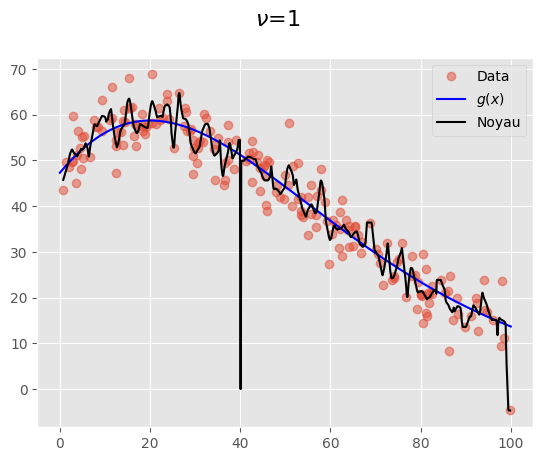

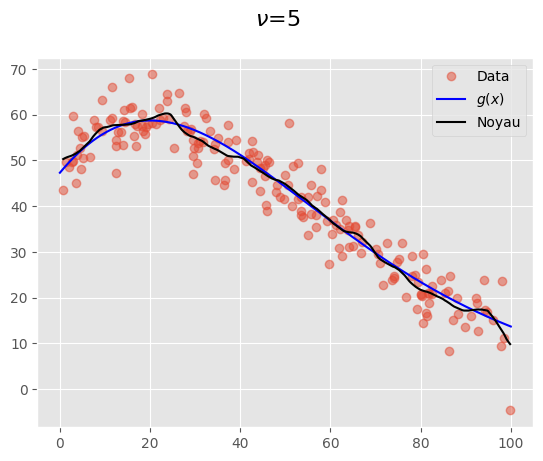

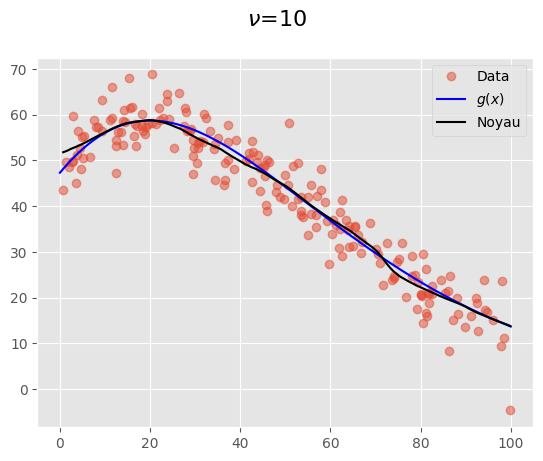

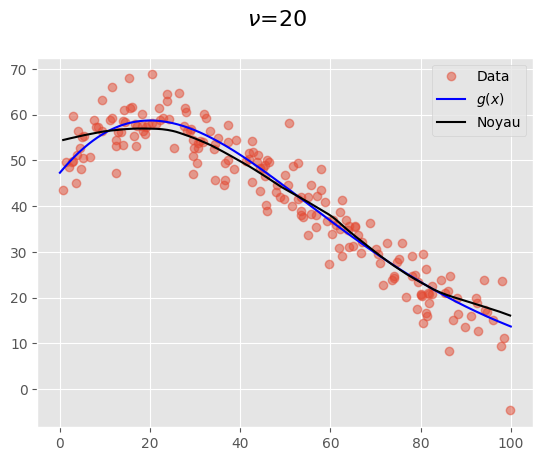

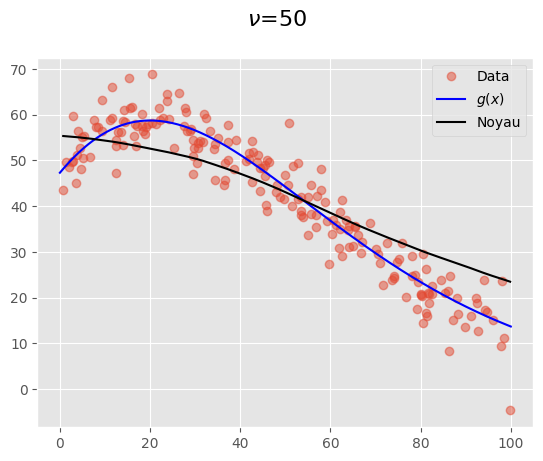

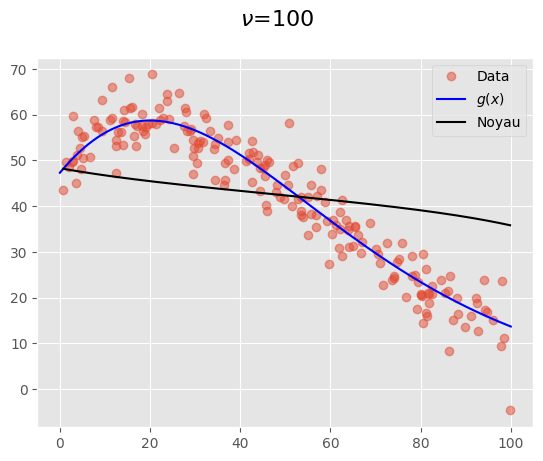

In [6]:
nus = [1,5,10,20,50,100]

for nu in nus:
    kreg = KRegression(X,Y,bw=nu)
    fig = plt.figure()
    plt.plot(X, Y, 'o', alpha=0.5, label='Data')
    plt.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
    kreg.plot_reg(color='k', label='Noyau')
    plt.legend(loc='best')
    fig.suptitle('$\\nu$={}'.format(round(nu,2)), fontsize=16)
    plt.show

Nous souhaitons proposer une méthode automatique pour estimer la valeur optimale de $\nu$. Pour cela, nous souhaitons évaluer l’erreur quadratique intégrée moyenne :
$$\textrm{MISE}(\nu)=\int_{\mathbb R}\mathbb E\left[\left(\hat g_{\nu}^K(x)-g(x)\right)^2|\mathcal D_{N}\right]dx$$

Soit $\mathcal D_{N,i}$ le dataset d'entrainement initial, d'où on a enlevé le $i$-eme couple, $(x_i,y_i)$. Soit $\hat g_{\nu,i}^K$ l'estimateur construit à partir de ce dataset incomplet. Un estimateur de $\textrm{MISE}(\nu)$, $\widehat{\textrm{MISE}}(\nu)$ peut alors être définit comme suit :

$$\widehat{\textrm{MISE}}(\nu):=\frac{1}{N}\sum_{i=1}^N(y_i-\hat g_{\nu,i}^K(x_i))^2$$

Un choix “optimal” de $\nu$ est alors obtenu par minimisation de $\widehat{\textrm{MISE}}(\nu)$:

$$\nu^{\mathrm{opt}}=\textrm{argmin}_{\nu>0}(\widehat{\textrm{MISE}}(\nu))$$

**4.** Implementer une méthode iterative pour pouvoir déterminer $\nu^{\textrm{opt}}$ (avec une `class`ou une/plusieurs fonctions) :

* Donné : dataset $\mathcal D_N$, noyau $K$, un vecteur `V` contenant un certain nombre de valeurs possibles $\nu$ à tester.
* Initialiser $\nu^{\textrm{opt}}=$ `V[0]` et $\widehat{\textrm{MISE}}^{\textrm{opt}}=\widehat{\textrm{MISE}}$(`V[0]`).
* Itérer sur les valeurs $\nu$ dans `V` pour minimiser $\widehat{\textrm{MISE}}$.
* Resultat : $\nu^{\textrm{opt}}, \widehat{\textrm{MISE}}^{\textrm{opt}}$

Grâce à cette méthode déterminer le $\nu$ optimale pour la régression avec le noyau $K$ donné: vous pouvez considérer l'intervalle `[5,20]` pour la recherche de $\nu$. Montrer graphiquement l'évolution de $\widehat{\textrm{MISE}}(\nu)$ pour tout $\nu$ testé. Représenter sur une même figure les données, la vrai fonction de régression, et son estimation avec le noyau $K$ et sa fenêtre optimale.

In [7]:
def mise(X,Y,nu):
    N=len(X)
    sum=0.0
    for i in range(N):
        X_i = np.delete(X,i)
        Y_i = np.delete(Y,i)
        y_hat = KRegression(X_i,Y_i,bw=nu).fit(np.array([X[i]]))
        sum += (Y[i]-y_hat)**2
    return sum/N

def optimal_window(X,Y,Nus=np.linspace(.1,10,100)):
    # X : data indep var (np.array)
    # Y : data dep var (np.array)
    # Nus : interval where nu research is performed (np.array)

    nu_opt = Nus[0]
    MISE_opt = mise(X,Y,nu_opt)
    MISE_list = [MISE_opt]

    for nu in Nus[1:]:
        MISE = mise(X,Y,nu)
        MISE_list.append(MISE)
        if MISE<MISE_opt:
            nu_opt = nu
            MISE_opt = MISE
    return nu_opt, MISE_opt, MISE_list

In [8]:
nu_opt, MISE_opt, MISE_list = optimal_window(X,Y,np.linspace(5,20,100))

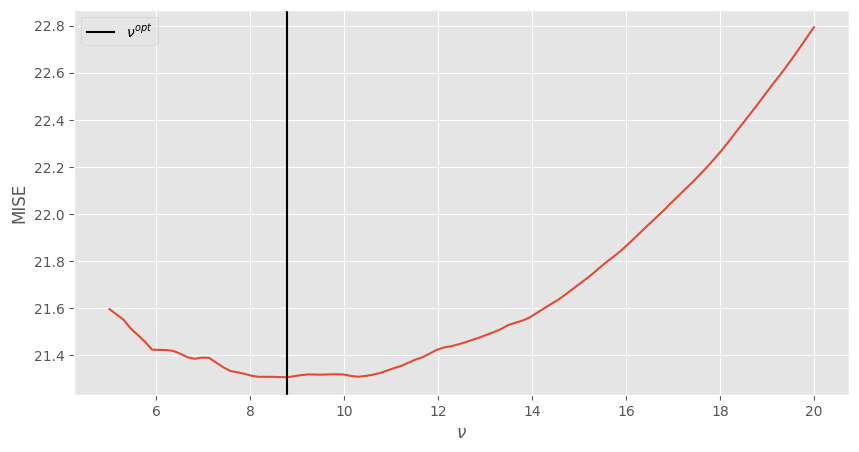

In [9]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(np.linspace(5,20,100),MISE_list)
ax.axvline(nu_opt,color='k',label='$\\nu^{opt}$')
ax.set(xlabel='$\\nu$',ylabel='MISE')
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

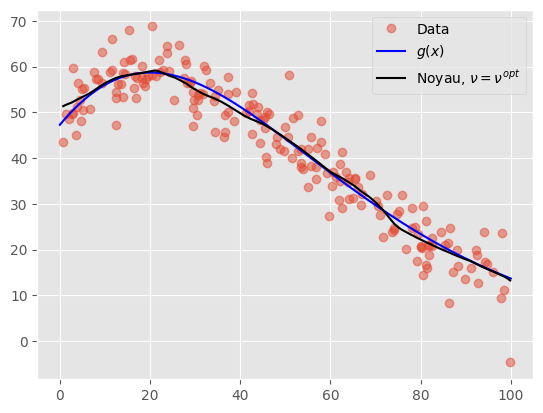

In [10]:
kreg = KRegression(X,Y,bw=nu_opt)
fig = plt.figure()
plt.plot(X, Y, 'o', alpha=0.5, label='Data')
plt.plot(x_lin, g(x_lin), 'b-', label='$g(x)$')
kreg.plot_reg(color='k', label='Noyau, $\\nu=\\nu^{opt}$')
plt.legend(loc='best')
plt.show

**5.** Commentez la qualité de cette regression à l'aide des résiduelles, que vous représenterez sous forme d'histogramme. Est-ce que une régression linéaire serait adapté dans ce cas ?

In [11]:
def residuals(self):
    return self.Y-self.fit(self.X)

KRegression.residuals=residuals

Mean = -0.0826293794712899; Std = 4.3558934389578825


[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Density')]

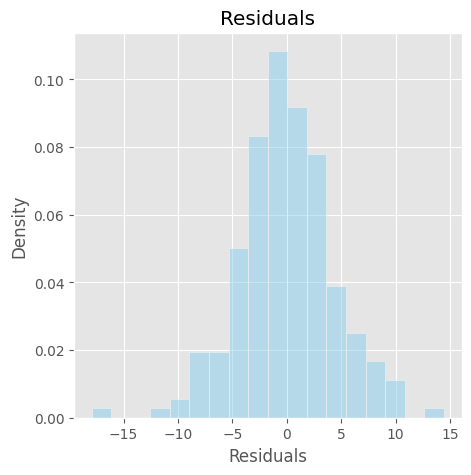

In [12]:
import seaborn as sns

Kreg = KRegression(X,Y,bw=nu_opt)
residuals = Kreg.residuals()

print(f'Mean = {np.mean(residuals)}; Std = {np.std(residuals)}')

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.title.set_text('Residuals')
ax= sns.histplot(residuals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax.set(xlabel='Residuals', ylabel='Density')

**Bonus.** La méthode proposé au point **4.** pour déterminer le $\nu$ optimale pour la regression avec noyaux peut s'appliquer aussi pour déterminer le $k$ optimale pour la régression avec $k$-plus-proches-voisins. Implémentez-la et comparez cette estimation avec celle obtenue avec le noyau $K$.

In [13]:
class KNNRegression:

    def __init__(self,X,Y,k):
        # X: independent variable (np.array)
        # Y: dependent variable (np.array)
        # k: number of neighbors
        self.X = X
        self.Y = Y
        self.k = k

    def fit(self,x):
        # x: np.array
        
        import pandas as pd
        df = pd.DataFrame(np.column_stack((self.X, self.Y)), columns=['X','Y'])
        
        hat_g = []
        for i in x:
            df_temp = df.copy()
            df_temp['dist']=abs(df_temp['X']-i)
            df_temp.sort_values(by=['dist'], inplace=True)
            sum = np.sum(df_temp['Y'].values[:self.k])
            hat_g.append(sum/self.k)
        return np.array(hat_g)

    def plot_reg(self,**kwargs):
        x_lin = np.linspace(min(self.X),max(self.X),1000)
        y_pred = self.fit(x_lin)
        return plt.plot(x_lin,y_pred, **kwargs)

    def residuals(self):
        return self.Y-self.fit(self.X)
        
    def plot_true_vs_predicted(self,**kwargs):
        return plt.scatter(self.Y,self.fit(self.X), **kwargs)

In [14]:
def mise_KNN(X,Y,k):
    N=len(X)
    sum=0.0
    for i in range(N):
        X_i = np.delete(X,i)
        Y_i = np.delete(Y,i)
        y_hat = KNNRegression(X_i,Y_i,k).fit(np.array([X[i]]))
        sum += (Y[i]-y_hat)**2
    return sum/N

def optimal_k(X,Y,K):
    # X : data indep var (np.array)
    # Y : data dep var (np.array)
    # Nus : interval where nu research is performed (np.array)

    k_opt = K[0]
    MISE_opt = mise_KNN(X,Y,k_opt)
    MISE_list = [MISE_opt]

    for k in K[1:]:
        MISE = mise_KNN(X,Y,k)
        MISE_list.append(MISE)
        if MISE<MISE_opt:
            k_opt = k
            MISE_opt = MISE
    return k_opt, MISE_opt, MISE_list

In [15]:
k_opt, MISE_opt, MISE_list = optimal_k(X,Y,np.arange(1,50))

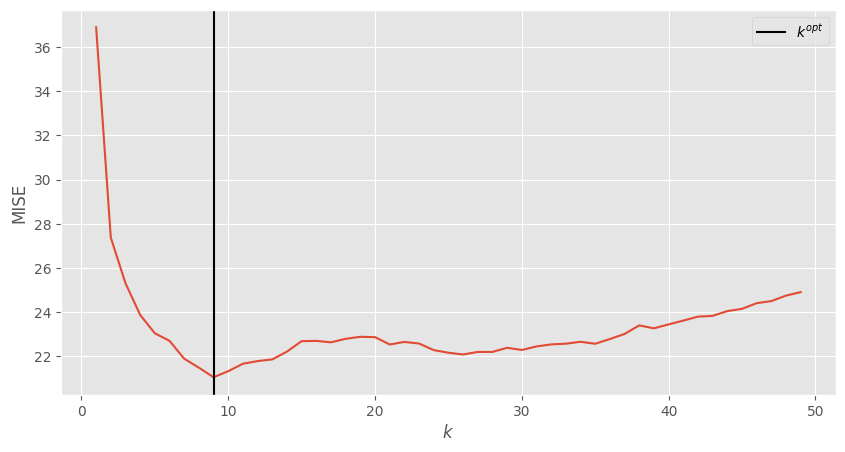

In [16]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.plot(np.arange(1,50),MISE_list)
ax.axvline(k_opt,color='k',label='$k^{opt}$')
ax.set(xlabel='$k$',ylabel='MISE')
plt.legend()

<function matplotlib.pyplot.show(close=None, block=None)>

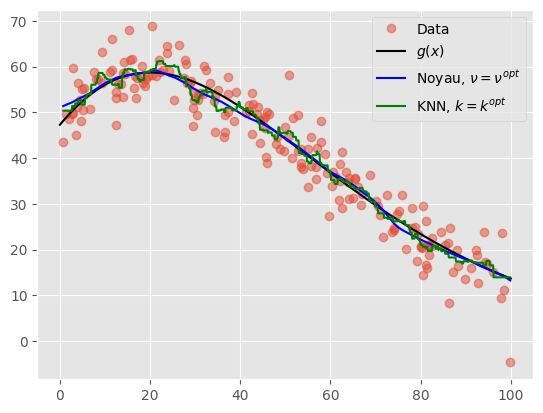

In [17]:
kreg = KRegression(X,Y,bw=nu_opt)
knnreg = KNNRegression(X,Y,k=k_opt)
fig = plt.figure()
plt.plot(X, Y, 'o', alpha=0.5, label='Data')
plt.plot(x_lin, g(x_lin), 'k-', label='$g(x)$')
kreg.plot_reg(color='b', label='Noyau, $\\nu=\\nu^{opt}$')
knnreg.plot_reg(color='g', label='KNN, $k=k^{opt}$')
plt.legend(loc='best')
plt.show

Kernel: Mean = -0.0826293794712899; Std = 4.3558934389578825
KNN: Mean = 0.07966214386571671; Std = 4.120151462576697


[Text(0.5, 0, 'Residuals'), Text(0, 0.5, 'Density')]

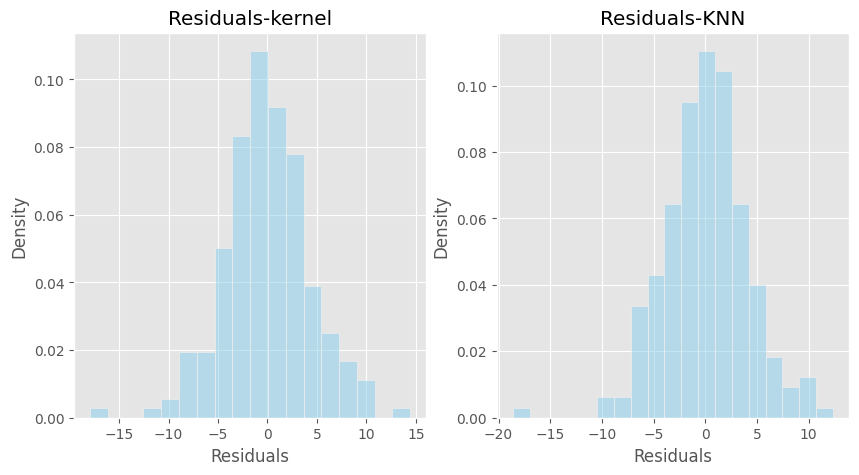

In [18]:
Kreg = KRegression(X,Y,bw=nu_opt)
residuals = Kreg.residuals()

KNNreg = KNNRegression(X,Y,k=k_opt)
KNNresiduals = KNNreg.residuals()

print(f'Kernel: Mean = {np.mean(residuals)}; Std = {np.std(residuals)}')
print(f'KNN: Mean = {np.mean(KNNresiduals)}; Std = {np.std(KNNresiduals)}')

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Residuals-kernel')
ax1= sns.histplot(residuals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax1.set(xlabel='Residuals', ylabel='Density')

ax2 = fig.add_subplot(122)
ax2.title.set_text('Residuals-KNN')
ax2= sns.histplot(KNNresiduals,
                     stat='density',
                     color="skyblue",
                     alpha=.5)
ax2.set(xlabel='Residuals', ylabel='Density')